<h1>Содержание<span class="tocSkip"></span></h1>
<br>
<div class="toc">
    <ul class="toc-item">
        <li>
            <span>
                <a href="#1-Подготовка-окружения">
                    <span class="toc-item-num">1&nbsp;&nbsp;</span>
                    Подготовка окружения
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#2-Загрузка-данных">
                    <span class="toc-item-num">2&nbsp;&nbsp;</span>
                    Загрузка данных
                </a>
            </span>
        </li>
        <li>
            <span>
                <a href="#3-Двунаправленная-LSTM">
                    <span class="toc-item-num">3&nbsp;&nbsp;</span>
                    Двунаправленная LSTM
                </a>
            </span>
            <ul class="toc-item">
                <li>
                    <span>
                        <a href="#3.1-Токенизация-слов">
                            <span class="toc-item-num">3.1&nbsp;&nbsp;</span>
                            Токенизация слов
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.2-Подготовка-модели">
                            <span class="toc-item-num">3.2&nbsp;&nbsp;</span>
                            Подготовка модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.3-Обучение-модели">
                            <span class="toc-item-num">3.3&nbsp;&nbsp;</span>
                            Обучение модели
                        </a>
                    </span>
                </li>
                <li>
                    <span>
                        <a href="#3.4-Генерация-текста">
                            <span class="toc-item-num">3.4&nbsp;&nbsp;</span>
                            Генерация текста
                        </a>
                    </span>
                </li>
            </ul>
        </li>
        <li>
            <span>
                <a href="#4-Общий-вывод">
                    <span class="toc-item-num">4&nbsp;&nbsp;</span>
                    Общий вывод
                </a>
            </span>
        </li>
    </ul>
</div>

# Генеративные текстовые нейросети | Двунаправленная LSTM

**Постановка задачи:** натренировать и сравнить качество нескольких генеративных текстовых моделей на одном из заданных текстовых датасетов.

**Источник данных:** [Harry Potter and the Methods of Rationality](https://hpmor.ru/).

**Характер данных:** текст книги "Гарри Поттер и методы рационального мышления".

**Основные этапы:** исследовать следующие нейросетевые архитектуры:

1. Simple RNN с посимвольной и пословной токенизацией.
2. Однонаправленная однослойная и многослойная LSTM c посимвольной токенизацией и токенизацией по словам и [на основе BPE](https://keras.io/api/keras_nlp/tokenizers/byte_pair_tokenizer/).
3. Двунаправленная LSTM.
4. *(На хорошую оценку)* трансформерная архитектура (GPT) "с нуля" [пример](https://keras.io/examples/generative/text_generation_gpt/).
5. *(На отличную оценку)* дообучение предобученной GPT-сети [пример](https://github.com/ZotovaElena/RuGPT3_finetuning).

---

# Реализации

1. [RNN с посимвольной токенизацией](RNN_char.ipynb)
2. [RNN с пословной токенизацией](RNN_word.ipynb)
3. [Однонаправленная LSTM + BPE](LSTM_unidirectional_BPE.ipynb)
4. Двунаправленная LSTM (текущий файл)
5. [Архитектура GPT](GPT_architecture.ipynb)
6. [Дообучение GPT](GPT_finetuning.ipynb)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 1 Подготовка окружения

Импорт библиотек:

In [1]:
import numpy as np

import random
import os

from tensorflow import keras
from tensorflow.keras.preprocessing import sequence

import keras.layers as l

from keras import models, callbacks, utils
from keras.preprocessing import text

# custom funcs
import utils.web_scrapping as web
import utils.process_checking as check
import utils.data_preprocessing as data_prep
import utils.charts_plotting as chart
import utils.predictions_making as pred

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## Загрузка данных

Формирование/загрузка набора данных в зависимости от его наличия:

In [2]:
data = web.load_data('https://hpmor.ru/', 'hpmor.txt')

Uploaded from data/hpmor.txt


Выведение на экран начала текста:

In [3]:
data[:500]

'гарри поттер и методы рационального мышления. элиезер юдковский (less wrong). петуния вышла замуж не за дурсля, а за университетского профессора, и гарри попал в гораздо более благоприятную среду. у него были частные учителя, дискуссии с отцом, а главное — книги, сотни и тысячи научных и фантастических книг. в 11 лет гарри знаком с квантовой механикой, когнитивной психологией, теорией вероятностей и другими вещами. но гарри не просто вундеркинд, у него есть загадочная тёмная сторона, которая явн'

Выведение на экран общего числа слов и предложений в тексте:

In [4]:
check.print_total(data)

Всего слов: 559791
Всего предложений: 37351


Разделение текста на отдельные предложения:

In [5]:
data_sentences = data_prep.split_into_sentences(data)

Выведение на экран начала текста:

In [6]:
data_sentences[:5]

['гарри поттер и методы рационального мышления',
 'элиезер юдковский',
 'петуния вышла замуж не за дурсля а за университетского профессора и гарри попал в гораздо более благоприятную среду',
 'у него были частные учителя дискуссии с отцом а главное  книги сотни и тысячи научных и фантастических книг',
 'в 11 лет гарри знаком с квантовой механикой когнитивной психологией теорией вероятностей и другими вещами']

Сокращение количества предложений для обеспечения работы модели:

In [7]:
data_sentences = data_sentences[:1000]

Выведение на экран количества слов в уменьшенном тексте:

In [8]:
check.print_total(' '.join(data_sentences))

Всего слов: 13549


<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 3 Двунаправленная LSTM

### 3.1 Токенизация слов

Объявление объекта токенизатора:

In [9]:
tokenizer = text.Tokenizer()

Токенизация предложений:

In [10]:
tokenizer.fit_on_texts(data_sentences)

Выведение на экран количества токенов в словаре:

In [11]:
print('Всего слов:', len(tokenizer.word_index))

Всего слов: 4768


Выведение на экран начала словаря токенов:

In [12]:
check.print_tokenizer_vocabulary(tokenizer)

[('и', 1),
 ('в', 2),
 ('не', 3),
 ('что', 4),
 ('гарри', 5),
 ('я', 6),
 ('на', 7),
 ('с', 8),
 ('макгонагалл', 9),
 ('но', 10)]

Формирование признаков:

In [13]:
features = data_prep.get_features(data_sentences, tokenizer)

Выведение на экран начала признаков:

In [14]:
features[:10]

[[5, 18],
 [5, 18, 1],
 [5, 18, 1, 565],
 [5, 18, 1, 565, 566],
 [5, 18, 1, 565, 566, 567],
 [1463, 1464],
 [108, 1465],
 [108, 1465, 1466],
 [108, 1465, 1466, 3],
 [108, 1465, 1466, 3, 25]]

Задание констант:

In [15]:
VOCAB_LEN = len(tokenizer.word_index) + 1
MAX_SEQ_LEN = max([len(x) for x in features])
BATCH_SIZE = 100

Преобразование признаков:

In [16]:
features = np.array(sequence.pad_sequences(features, maxlen=MAX_SEQ_LEN, padding='pre'))

Выведение на экран начала преобразованных признаков:

In [17]:
features[:10]

array([[   0,    0,    0, ...,    0,    5,   18],
       [   0,    0,    0, ...,    5,   18,    1],
       [   0,    0,    0, ...,   18,    1,  565],
       ...,
       [   0,    0,    0, ...,  108, 1465, 1466],
       [   0,    0,    0, ..., 1465, 1466,    3],
       [   0,    0,    0, ..., 1466,    3,   25]])

Задание признаков и целевого признака:

In [18]:
features, target = features[:,:-1], features[:,-1]
target = utils.to_categorical(target, num_classes=VOCAB_LEN)

Выведение на экран экземпляра признаков и целевого признака:

In [19]:
check.print_single_element(features, target, tokenizer.index_word)

Признаки (103,):
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    2  289 1879 1880  351  144 1881   36   20 1882
  919  920  464  117 1883]

Перевод в текст:
в глазах петунии стояли слёзы лили отказывала мне по разным нелепым причинам говорила будто наступит

Целевой признак (4769,):
921

Перевод в текст:
конец



---

### 3.2 Подготовка модели

Задание модели:

In [20]:
model = models.Sequential([
    l.Embedding(VOCAB_LEN, BATCH_SIZE, input_length=MAX_SEQ_LEN-1),
    l.Bidirectional(l.LSTM(150, return_sequences=True)),
    l.Dropout(0.2),
    l.LSTM(100),
    l.Dense(VOCAB_LEN / 2, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    l.Dense(VOCAB_LEN, activation='softmax')
])

Выведение на экран таблицы поведения параметров на слоях нейросети:

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 103, 100)          476900    
                                                                 
 bidirectional (Bidirectiona  (None, 103, 300)         301200    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 103, 300)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 2384)              240784    
                                                                 
 dense_1 (Dense)             (None, 4769)              11374065  
                                                        

Проверка наличия папки для хранения изображений:

In [22]:
if os.path.isdir('images/') == False:
    os.mkdir('images/')

Выведение на экран отображения послойной обработки данных моделью:

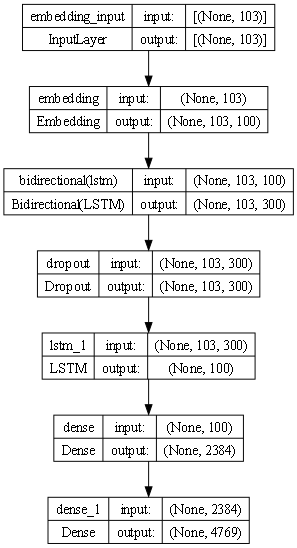

In [23]:
utils.plot_model(model, 'images/lstm_bi_model.png', show_shapes=True, dpi=70)

---

### 3.3 Обучение модели

Проверка наличия папки для хранения контрольных точек:

In [24]:
if os.path.isdir('checkpoints/') == False:
    os.mkdir('checkpoints/')

Задание пути для хранения контрольных точек:

In [25]:
path_checkpoints = 'checkpoints/lstm_bi'

Проверка наличия папки для хранения контрольных точек:

In [26]:
if os.path.isdir(path_checkpoints) == False:
    os.mkdir(path_checkpoints)

Задание коллбека точек сохранения:

In [27]:
checkpoint_path = os.path.join(path_checkpoints, 'checkpoint_{epoch}')
checkpoint_callback = callbacks.ModelCheckpoint(filepath=checkpoint_path, save_weights_only=True)

Компиляция модели с оптимизатором и функцией потерь:

In [28]:
model.compile( optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Обучение модели:

In [ ]:
history = model.fit(features, target, epochs=50, validation_split=0.2, verbose=1)

Epoch 1/50
318/318 [==============================] - 188s 581ms/step - loss: 7.8204 - accuracy: 0.0246 - val_loss: 7.6170 - val_accuracy: 0.0220
Epoch 2/50
 72/318 [=====>........................] - ETA: 2:18 - loss: 7.2643 - accuracy: 0.0239

Выведение на экран графика значений функции потерь и качества модели:

In [ ]:
chart.plot_loss_acc(history)

Сброс состояния модели:

In [ ]:
model.reset_states()

---

### 3.4 Генерация текста

Выведение на экран результата предсказаний:

In [ ]:
pred.predict_next_word(
    sample='гарри поттер',
    model=model,
    tokenizer=tokenizer,
    n_words=100,
    max_len=MAX_SEQ_LEN
)

Выведение на экран результата предсказаний:

In [ ]:
pred.predict_next_word(
    sample='однажды в зачарованном лесу',
    model=model,
    tokenizer=tokenizer,
    n_words=100,
    max_len=MAX_SEQ_LEN
)

<div style="background-color: blue; height: 2px; margin: 10px 0;"></div>

## 4 Общий вывод

В ходе исследования была построена модель нейросети, основанная на слое двунаправленной LSTM для обеспечения ей временной памяти. Модель продемонстрировала неплохие результаты предсказания следующего слова на основе заданного ей запроса. Результат можно улучшить, увеличив количество обрабатываемых данных, однако это возможно только при наличии удовлетворяющих задаче технических средств.

<div style="text-align: center; font-size: 20px; padding: 15px 0;">
    <a href="#Содержание" data-toc-modified-id="Содержание" style="text-decoration: none; color: #296eaa; border: 2px dashed #296eaa; opacity: 0.8; border-radius: 3px; padding: 10px 80px;">
        В начало файла ↑
    </a>
</div>